In [27]:
import sys, os
sys.path.insert(1, '../mindeye/src/')

from diffusers import T2IAdapter,  EulerDiscreteScheduler, AutoencoderKL, MultiAdapter, StableDiffusionAdapterPipeline
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms 
from torchvision.utils import make_grid

# import utils 
from models import Clipper, BrainNetwork, BrainDiffusionPriorOld 

import clip 
from clip_client import ClipClient, Modality
import urllib
import io

In [44]:
subj = 1
#for vdvae depth initial image
vdvae_num_layers = 47

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
gt_stim_test = np.load('../data/processed_data/subj{:02d}/nsd_test_stim_sub1.npy'.format(subj,subj)).astype(np.uint8)
caps_test = np.load('../data/processed_data/subj{:02d}/nsd_test_cap_sub{}.npy'.format(subj,subj))
fmri_test = np.load('../data/processed_data/subj{:02d}/nsd_test_fmriavg_nsdgeneral_sub{}.npy'.format(subj,subj))
# pred_cliptext = np.load('../data/predicted_features/subj{:02d}/nsd_compel_cliptext_predtest_nsdgeneral.npy'.format(subj))
# pred_cliptext = torch.from_numpy(pred_cliptext)

### load BrainNetwork (voxel2clip) and Diffusion Prior

In [5]:
if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386
print("subj",subj,"num_voxels",num_voxels)

subj 1 num_voxels 15724


In [6]:
# CLS model
out_dim = 768
clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=False, device=device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

diffusion_prior = BrainDiffusionPriorOld.from_pretrained(
    # kwargs for DiffusionPriorNetwork
    dict(),
    # kwargs for DiffusionNetwork
    dict(
        condition_on_text_encodings=False,
        timesteps=1000,
        voxel2clip=voxel2clip,
    ),
    voxel2clip_path=None,
    ckpt_dir='../mindeye/checkpoints',
)

model_name = "prior_1x768_final_subj01_bimixco_softclip_byol"
outdir = f'../mindeye/train_logs/{model_name}/'
ckpt_path = os.path.join(outdir, f'last.pth')

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior.load_state_dict(state_dict,strict=False)
diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]

ViT-L/14 cuda
ckpt_path ../mindeye/train_logs/prior_1x768_final_subj01_bimixco_softclip_byol/last.pth
EPOCH:  299


### function to get CLIP embeddings from fMRI

In [7]:
def get_clip_embeddings(voxels, diffusion_prior, recons_per_sample=1, seed=0):
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)
    brain_clip_embeddings0, proj_embeddings = diffusion_prior.voxel2clip(voxels.to(device).float())
    # brain_clip_embeddings0 = brain_clip_embeddings0.view(len(voxels),-1,768)
    brain_clip_embeddings0 = brain_clip_embeddings0.view(-1,768)
    brain_clip_embeddings0 = brain_clip_embeddings0.repeat(recons_per_sample, 1)
    brain_clip_embeddings = diffusion_prior.p_sample_loop(brain_clip_embeddings0.shape,
                            text_cond = dict(text_embed = brain_clip_embeddings0),
                            cond_scale = 1., timesteps = 1000, #1000 timesteps used from nousr pretraining
                            generator=generator)
    brain_clip_embeddings = brain_clip_embeddings.unsqueeze(1) #(1,1,768)

    return brain_clip_embeddings 

### load CLIP Client and ClIP retrieval functions

In [8]:
model, preprocess = clip.load("ViT-L/14", device="cpu", jit=False)

client = ClipClient(
    url="https://knn.laion.ai/knn-service",
    indice_name="laion5B-L-14",
    aesthetic_score=9,
    aesthetic_weight=0.5,
    modality=Modality.IMAGE,
    num_images=10,
)

In [9]:
def log_result(result):
    id, caption, url, similarity = result["id"], result["caption"], result["url"], result["similarity"]
    print(f"id: {id}")
    print(f"caption: {caption}")
    print(f"url: {url}")
    print(f"similarity: {similarity}")
    # display(Image(url=url, unconfined=True))

def download_image(url):
    urllib_request = urllib.request.Request(
        url,
        data=None,
        headers={"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:72.0) Gecko/20100101 Firefox/72.0"},
    )
    with urllib.request.urlopen(urllib_request, timeout=10) as r:
        img_stream = io.BytesIO(r.read())
    return img_stream

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

def get_text_emb(text):
    with torch.no_grad():
        text_emb = model.encode_text(clip.tokenize([text], truncate=True).to("cpu"))
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb.cpu().detach().numpy().astype("float32")[0]
    return text_emb


def get_image_emb(image_url):
    with torch.no_grad():
        image = Image.open(download_image(image_url))
        image_emb = model.encode_image(preprocess(image).unsqueeze(0).to("cpu"))
        image_emb /= image_emb.norm(dim=-1, keepdim=True)
        image_emb = image_emb.cpu().detach().numpy().astype("float32")[0]
        return image_emb

### load Stable Diffusion with T2I Adapters

In [22]:
adapters = MultiAdapter(
    [
        T2IAdapter.from_pretrained("TencentARC/t2iadapter_color_sd14v1", torch_dtype=torch.float16),
        T2IAdapter.from_pretrained("TencentARC/t2iadapter_depth_sd14v1", torch_dtype=torch.float16),
    ]
)

model_id = "CompVis/stable-diffusion-v1-4"
vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-ema', torch_dtype=torch.float16)
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionAdapterPipeline.from_pretrained(
    model_id, vae=vae, adapter=adapters, scheduler=scheduler, torch_dtype=torch.float16, variant="fp16"
).to(device)

safety_checker\model.fp16.safetensors not found
Loading pipeline components...:  14%|█▍        | 1/7 [00:01<00:07,  1.20s/it]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


### Reconstruction

In [23]:
def get_color_pallete(img):
    img = img.resize((8,8))
    color_pallete = img.resize((512, 512), resample=Image.Resampling.NEAREST)

    return color_pallete

In [24]:
negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"
generator = torch.manual_seed(777) 

In [39]:
for ndx, voxels in enumerate(torch.from_numpy(fmri_test)):
    print(ndx)

    clip_embs = get_clip_embeddings(voxels.unsqueeze(0), diffusion_prior)
    query_res = client.query(embedding_input=clip_embs[0][0].tolist())
    caps = query_res[0]["caption"]

    print("ground truth captions: ", list(caps_test[caps_test!='']))
    print("predicted captions: ", caps)
    print("retrieved embs similarity: ", query_res[0]["similarity"])

    color_pallete = get_color_pallete(Image.open('../results/lvae/subj01/stim/{}.png'.format(ndx)))
    depth_img = Image.open('../results/vdvae/subj01/depth_stim_{}l/{}.png'.format(vdvae_num_layers,ndx))

    gen_images = pipe(
    prompt = caps,
    negative_prompt=negative_prompt,
    image=[color_pallete, depth_img],
    adapter_conditioning_scale=[0.9, 0.8],
    num_inference_steps=50,
    guidance_scale=5.5,  
    generator=generator,
    num_images_per_prompt=3,
    ).images

    break

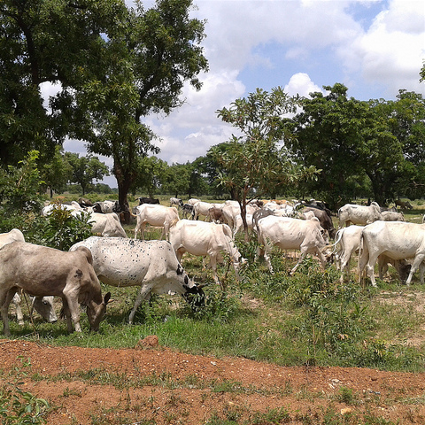

In [40]:
Image.fromarray(gt_stim_test[ndx])

In [10]:
transform = transforms.Compose([ 
    transforms.PILToTensor() 
]) 

In [11]:
images = [transform(im) for im in gen_images]
grid = make_grid(images, nrow=3)
grid = transforms.ToPILImage()(grid)
grid

NameError: name 'gen_images' is not defined

In [36]:
voxels.shape

torch.Size([15724])

### test 

In [46]:
import webdataset as wds
from tqdm import tqdm
from itertools import islice
import torch
import torchvision.transforms as transforms 

In [47]:
sub=1

In [48]:
data_path='../mindeye/data'
# val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{sub}_" + "{0..1}.tar"
# meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{sub}.json"
val_url = f"{data_path}/test_subj0{sub}_" + "{0..1}.tar"
meta_url = f"{data_path}/metadata_subj0{sub}.json"
num_train = 8559 + 300
num_val = 982
batch_size = val_batch_size = 1
voxels_key = 'nsdgeneral.npy' # 1d inputs

val_data = wds.WebDataset(val_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(val_batch_size, partial=False)

val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, coco) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    if val_i > 3:
        break

idx 0
voxel.shape torch.Size([1, 3, 15724])
img_input.shape torch.Size([1, 3, 256, 256])
idx 1
voxel.shape torch.Size([1, 3, 15724])
img_input.shape torch.Size([1, 3, 256, 256])
idx 2
voxel.shape torch.Size([1, 3, 15724])
img_input.shape torch.Size([1, 3, 256, 256])
idx 3
voxel.shape torch.Size([1, 3, 15724])
img_input.shape torch.Size([1, 3, 256, 256])
idx 4
voxel.shape torch.Size([1, 3, 15724])
img_input.shape torch.Size([1, 3, 256, 256])


In [49]:
def torch_to_image(x):
    if x.ndim==4:
        x=x[0]
    return transforms.ToPILImage()(x)

0
torch.Size([1, 15724])


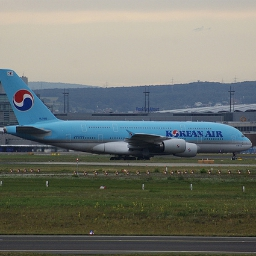

In [51]:
ndx=110

with torch.no_grad():
    for ndx, (voxel, img, coco) in enumerate(islice(val_data, ndx, ndx+1)):
        voxel=torch.from_numpy(voxel)
        voxel = torch.mean(voxel,axis=1).to(device)
        print(ndx)
        print(voxel.shape)
        # ae_preds = voxel2sd(voxel.float())
        # print(ae_preds.shape)
        # print(img.shape)
        


In [ ]:
img = torch_to_image(img)
img

In [52]:
from controlnet_aux.midas import MidasDetector 

midas_depth = MidasDetector.from_pretrained(
  "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large"
).to(device)

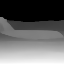

In [53]:
dpth = midas_depth(img, detect_resolution=256, image_resolution=64)
dpth

In [58]:
ndx=110
init_img = Image.open('../results/lvae/subj01/{}.png'.format(ndx))
print(init_img.size)
init_img

FileNotFoundError: [Errno 2] No such file or directory: '../results/lvae/subj01/110.png'

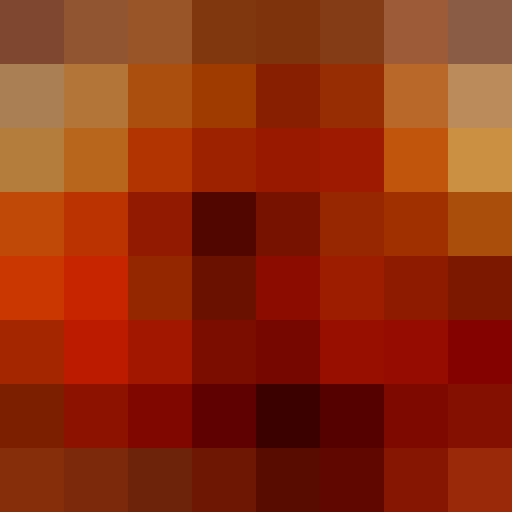

In [55]:
color_pallete = init_img.resize((8,8))
color_pallete = color_pallete.resize((512, 512), resample=Image.Resampling.NEAREST)
color_pallete

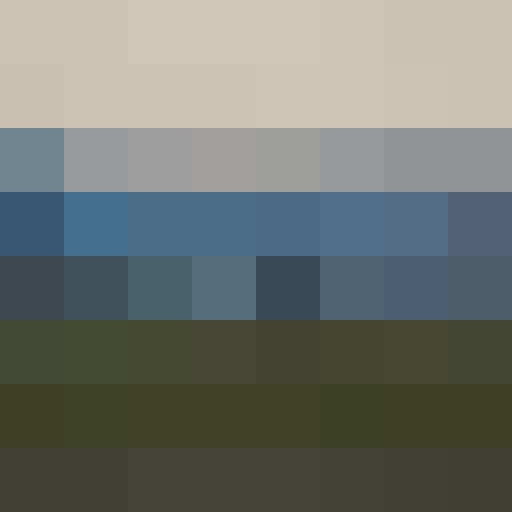

In [59]:
color_pallete = img.resize((8,8))
color_pallete = color_pallete.resize((512, 512), resample=Image.Resampling.NEAREST)
color_pallete

In [41]:
test_color_adapter = T2IAdapter.from_pretrained("SargeZT/t2i-adapter-sdxl-multi", subfolder="color", torch_dtype=torch.float16)

c:\Users\gabri\anaconda3\envs\brain-decoding\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gabri\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
The config attributes {'name': 'color'} were passed to T2IAdapter, but are not expected and will be ignored. Please verify your c

In [43]:
from diffusers import EulerAncestralDiscreteScheduler, StableDiffusionXLAdapterPipeline

In [57]:
# load euler_a scheduler
model_id = 'stabilityai/stable-diffusion-xl-base-1.0'
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
vae=AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

# sdxl_adapter = T2IAdapter.from_pretrained("TencentARC/t2i-adapter-depth-midas-sdxl-1.0", torch_dtype=torch.float16, variant="fp16").to(device)

# pipe = StableDiffusionXLAdapterPipeline.from_pretrained(
#     model_id, vae=vae, adapter=sdxl_adapter, scheduler=scheduler, torch_dtype=torch.float16, variant="fp16", 
# ).to(device)

test_color_adapter = test_color_adapter.to(device)

pipe = StableDiffusionXLAdapterPipeline.from_pretrained(
    model_id, vae=vae, adapter=test_color_adapter, scheduler=scheduler, torch_dtype=torch.float16, variant="fp16", 
).to(device)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]





Fetching 17 files:  12%|█▏        | 2/17 [00:01<00:13,  1.13it/s]



















































































































































































Fetching 17 files:  18%|█▊        | 3/17 [00:51<04:55, 21.10s/it]















































































































































































































































































































































Fetching 17 files:  29%|██▉       | 5/17 [02:29<07:17, 36.46s/it]



































































































































































































































In [60]:
negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"

In [61]:
gen_images = pipe(
  prompt = "A Icelandair Airliner is preparing for take off",
  negative_prompt=negative_prompt,
  image=color_pallete,
  adapter_conditioning_scale=1,
  num_inference_steps=50,
  guidance_scale=7.5,  
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (32) must match the size of tensor b (64) at non-singleton dimension 3

In [42]:
# clip_embs = get_clip_embeddings(voxel.float(), diffusion_prior)
# query_res = client.query(embedding_input=clip_embs[0][0].tolist())
# caps = query_res[0]["caption"]
# log_result(query_res[0])

In [13]:
from controlnet_aux.midas import MidasDetector 

midas_depth = MidasDetector.from_pretrained(
  "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large"
).to(device)

c:\Users\gabri\anaconda3\envs\brain-decoding\Lib\site-packages\controlnet_aux\mediapipe_face\mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [24]:
ndx=110

with torch.no_grad():
    for ndx, (voxel, img, coco) in enumerate(islice(val_data, ndx, ndx+1)):
        print(type(img), img.shape)
        break

<class 'torch.Tensor'> torch.Size([1, 3, 256, 256])


In [17]:
# midas_input = transforms.ToPILImage()(img)
# # print(type(img), img.shape)

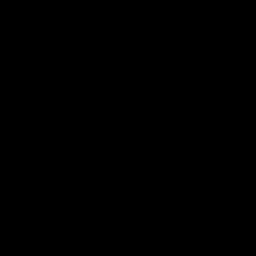

In [46]:
from PIL import Image

Image.fromarray(img[0].permute(1,2,0).numpy().astype(np.uint8))

In [50]:
dp = midas_depth(transforms.ToPILImage()(img[0]), detect_resolution=256, image_resolution=64)
# dp = midas_depth(midas_depth(img[0].permute(1,2,0), detect_resolution=256, image_resolution=64))

In [51]:
print(type(dp), dp.size)

<class 'PIL.Image.Image'> (64, 64)


In [56]:
arr = np.array(dp)
print(arr.shape)

(64, 64, 3)


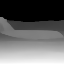

In [55]:
Image.fromarray(arr)

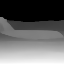

In [52]:
dp1 = transforms.ToTensor()(dp)
transforms.ToPILImage()(dp1)

In [26]:
if not None:
    print("test")

test


In [66]:
print(img_input.shape, img_input.dtype)

torch.Size([1, 3, 256, 256]) torch.float32


In [72]:
test = transforms.functional.resize(img_input,(64,64))
print(test.shape, test.dtype)
# img = torch.tensor(np.array(img)).float()

torch.Size([1, 3, 64, 64]) torch.float32


c:\Users\gabri\anaconda3\envs\brain-decoding\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


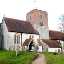

In [75]:
transforms.ToPILImage()(test[0])

In [76]:
import torch.nn.functional as F

In [78]:
test2 = F.interpolate(img_input, (64, 64), mode='bilinear', align_corners=False, antialias=True)
print(test2.shape, test2.dtype)

torch.Size([1, 3, 64, 64]) torch.float32


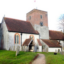

In [79]:
transforms.ToPILImage()(test2[0])

In [80]:
test_np = np.array(test[0].permute(1,2,0))

In [83]:
test_np.shape

(64, 64, 3)

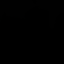

In [82]:
Image.fromarray(test_np.astype(np.uint8))

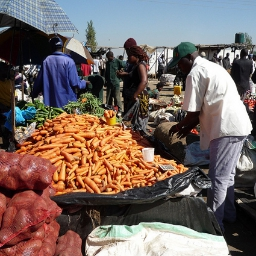

In [85]:
wds_stim = Image.open('d:/dev/backup-brain-decoding-files/ground_truth_stim_images/ground_truth_stim/0.png')
print(wds_stim.size)
wds_stim

In [104]:
wds_stim = transforms.ToPILImage()(img_input[0])

In [101]:
wds_stim_64 = wds_stim.resize((64,64))
test3 = torch.tensor(np.array(wds_stim_64)).float()
print(wds_stim_64.size)
print(test3.shape, test3.dtype)

(64, 64)
torch.Size([64, 64, 3]) torch.float32


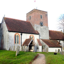

In [102]:
Image.fromarray(np.array(test3).astype(np.uint8))

In [105]:
wds_stim_64 = transforms.functional.resize(wds_stim, (64,64))
nparr = np.array(wds_stim_64).astype(np.uint8)
test4 = torch.tensor(nparr).float()
print(wds_stim_64.size, type(wds_stim_64))
print(type(nparr), nparr.shape, nparr.dtype)
print(test4.shape, test4.dtype)

(64, 64) <class 'PIL.Image.Image'>
<class 'numpy.ndarray'> (64, 64, 3) uint8
torch.Size([64, 64, 3]) torch.float32


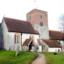

In [106]:
Image.fromarray(nparr)

In [120]:
if None:
    print("test")